In [1]:
import mathutils
import numpy as np
from plyfile import PlyData, PlyElement

import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy.spatial import KDTree

In [8]:
def parse_pointcloud(scene_path: str):
    with open(scene_path, "rb") as f:
        scene_cloud = PlyData.read(f)

    xyz = np.stack((np.asarray(scene_cloud.elements[0]["x"]),
                    np.asarray(scene_cloud.elements[0]["y"]),
                    np.asarray(scene_cloud.elements[0]["z"])), axis=1)

    N = len(xyz)

    log_scales = np.stack((np.asarray(scene_cloud.elements[0]["scale_0"]),
                        np.asarray(scene_cloud.elements[0]["scale_1"]),
                        np.asarray(scene_cloud.elements[0]["scale_2"])), axis=1)

    scales = np.exp(log_scales)

    quats = np.stack((np.asarray(scene_cloud.elements[0]["rot_0"]),
                        np.asarray(scene_cloud.elements[0]["rot_1"]),
                        np.asarray(scene_cloud.elements[0]["rot_2"]),
                        np.asarray(scene_cloud.elements[0]["rot_3"])), axis=1)

    rots_euler = np.zeros((N, 3))

    for i in range(N):
        quat = mathutils.Quaternion(quats[i].tolist())
        euler = quat.to_euler()
        rots_euler[i] = (euler.x, euler.y, euler.z)
    
    opacities = scene_cloud.elements[0]["opacity"]
    
    return xyz, scales, rots_euler, opacities

In [9]:
locations, scales, rots, opacities = parse_pointcloud("C:\\Users\\rohan\\Documents\\sp24\\cs280\\final_proj\\scenes\\suess_0.ply")

In [10]:
locations, scales, rots, opacities = locations[opacities > 0.5], scales[opacities > 0.5], rots[opacities > 0.5], opacities[opacities > 0.5]

In [11]:
len(locations)

575267

In [13]:
# Sample data points
points = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])

# Construct KDTree
kdtree = KDTree(points)

# Query point
query_point = np.array([2.5, 3.5])

# Find nearest neighbor
nearest_dist, nearest_idx = kdtree.query(query_point)

# Print result
print("Nearest neighbor:", points[nearest_idx])
print("Distance:", nearest_dist)

Nearest neighbor: [2 3]
Distance: 0.7071067811865476


In [14]:
kdtree = KDTree(locations)

In [15]:
# sample query point
query_point = locations[0]
distances, indices = kdtree.query(query_point, k=3)

In [16]:
volumes = np.prod(scales, axis=1)
volumes.shape, np.min(volumes), np.max(volumes)

((575267,), 1.1089792e-09, 0.09037863)

In [17]:
# sample point in kd tree weighted by volume
probs = volumes / np.sum(volumes)
sample_idx = np.random.choice(np.arange(len(locations)), p=probs)
sample_idx

202733

In [18]:
close_neighbors, close_idx = kdtree.query(locations[sample_idx], k=2)

$$\textrm{attraction}_{V,v} = \frac{GV}{vr^2}$$
$$\textrm{similarity}_{P,s} = $$
Do something with difference between largest axes of veggie solid and gaussian group (maybe PCA vectors? idk)

In [19]:
locations[close_idx]

array([[-19.393051 ,  -2.201385 ,   0.8507884],
       [-18.776031 ,  -1.9297487,   1.1846306]], dtype=float32)

In [20]:
points_for_hull = []
for i in close_idx:
    loc = locations[i]
    scale = scales[i]
    # set rot to a quaternion representation of the euler angles
    rot = rots[i]
    quat = mathutils.Quaternion(rot)
    # rotate the x scale vector by the quaternion
    x_scale = np.array(quat @ mathutils.Vector((scale[0], 0, 0)))
    y_scale = np.array(quat @ mathutils.Vector((0, scale[1], 0)))
    z_scale = np.array(quat @ mathutils.Vector((0, 0, scale[2])))
    points_for_hull.append(loc + x_scale)
    points_for_hull.append(loc + y_scale)
    points_for_hull.append(loc + z_scale)
    points_for_hull.append(loc - x_scale)
    points_for_hull.append(loc - y_scale)
    points_for_hull.append(loc - z_scale)


    

In [21]:
points_for_hull, locations[close_idx]

([array([-19.65784487,  -2.20545209,   0.75834461]),
  array([-19.47263433,  -2.04733056,   1.07196686]),
  array([-19.3308722 ,  -1.89415124,   0.65916786]),
  array([-19.12825742,  -2.19731796,   0.94323222]),
  array([-19.31346796,  -2.35543948,   0.62960997]),
  array([-19.45523009,  -2.5086188 ,   1.04240897]),
  array([-18.7339285 ,  -1.78007731,   1.22600173]),
  array([-18.92774147,  -1.88054931,   1.16103232]),
  array([-18.82125751,  -1.97266299,   1.38591117]),
  array([-18.81813449,  -2.07942   ,   1.14325953]),
  array([-18.62432152,  -1.978948  ,   1.20822894]),
  array([-18.73080548,  -1.88683432,   0.9833501 ])],
 array([[-19.393051 ,  -2.201385 ,   0.8507884],
        [-18.776031 ,  -1.9297487,   1.1846306]], dtype=float32))

In [22]:
from matplotlib import pyplot as plt

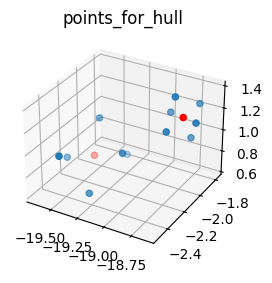

<Figure size 640x480 with 0 Axes>

In [23]:
# Unpack the points
x1, y1, z1 = zip(*points_for_hull)
x2, y2, z2 = zip(*locations[close_idx])

# Create two subplots
fig = plt.figure()

# Create first subplot for points_for_hull
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x1, y1, z1)
ax1.set_title('points_for_hull')

# add the points_for_hull to the plot in a different color
ax1.scatter(x2, y2, z2, color='red')

# Display the plots
plt.show()

#clear the figure
plt.clf()

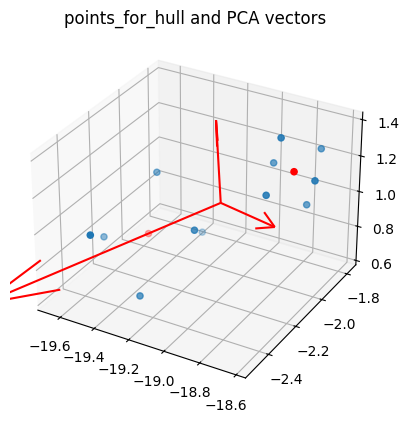

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np

# Convert list of tuples to numpy array
points_array = np.array(points_for_hull)

# get center
center = np.mean(points_array, axis=0)

# Perform PCA
pca = PCA(n_components=3)
pca.fit(points_array)

# Get the PCA vectors
pca_vectors = pca.components_

# Unpack the points
x, y, z = zip(*points_for_hull)
location_x, location_y, location_z = zip(*locations[close_idx])

# Create a subplot for the points and PCA vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points_for_hull
ax.scatter(x, y, z)
ax.scatter(location_x, location_y, location_z, color='red')

# Plot PCA vectors from center
for length, vector in zip(pca.explained_variance_, pca_vectors):
    v = vector * 3 * np.sqrt(length)
    ax.quiver(*center, *v, color='red')

ax.set_title('points_for_hull and PCA vectors')

# Display the plot
plt.show()

In [25]:
broccoli = PlyData.read("C:\\Users\\rohan\\Documents\\sp24\\cs280\\final_proj\\veggies\\pointclouds\\broccoli.ply")

In [26]:
x_max = np.max(broccoli.elements[0]["x"])
x_min = np.min(broccoli.elements[0]["x"])
y_max = np.max(broccoli.elements[0]["y"])
y_min = np.min(broccoli.elements[0]["y"])
z_max = np.max(broccoli.elements[0]["z"])
z_min = np.min(broccoli.elements[0]["z"])

print(x_max, x_min, y_max, y_min, z_max, z_min)

0.09313139 -0.10969846 0.09205946 -0.113879025 0.24095803 0.00042984978


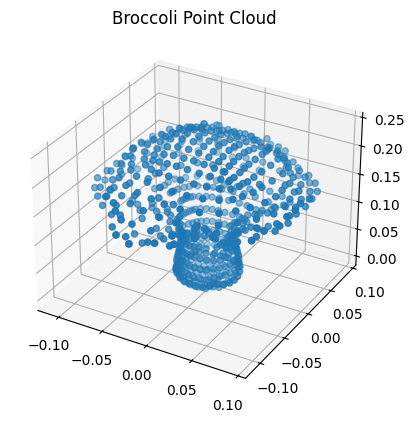

In [27]:
# plot the broccoli point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(broccoli.elements[0]["x"], broccoli.elements[0]["y"], broccoli.elements[0]["z"])
ax.set_title('Broccoli Point Cloud')
plt.show()

In [28]:
def get_scales(veggie: str):
    veggie = PlyData.read(f"C:\\Users\\rohan\\Documents\\sp24\\cs280\\final_proj\\veggies\\pointclouds\\{veggie}.ply")
    x_min = np.min(veggie.elements[0]["x"])
    x_max = np.max(veggie.elements[0]["x"])
    y_min = np.min(veggie.elements[0]["y"])
    y_max = np.max(veggie.elements[0]["y"])
    z_min = np.min(veggie.elements[0]["z"])
    z_max = np.max(veggie.elements[0]["z"])
    return (x_max - x_min, y_max - y_min, z_max - z_min)


In [30]:
all_scales = []
all_scales.append(get_scales("apple"))
all_scales.append(get_scales("bell_pepper"))
all_scales.append(get_scales("broccoli"))
all_scales.append(get_scales("cabbage"))
all_scales.append(get_scales("carrot"))
all_scales.append(get_scales("garlic"))
all_scales.append(get_scales("gourd"))
all_scales.append(get_scales("mango"))
all_scales.append(get_scales("orange"))
all_scales.append(get_scales("peach_normal"))
#all_scales.append(get_scales("peach"))
#all_scales.append(get_scales("pear"))
all_scales.append(get_scales("potato"))
all_scales.append(get_scales("pumpkin"))
all_scales.append(get_scales("russet_potato"))
all_scales.append(get_scales("sweet_pepper"))
all_veggies = ["apple", "bell_pepper", "broccoli", "cabbage", "carrot", "garlic", "gourd", "mango", "orange", "pear", "potato", "pumpkin", "russet_potato", "sweet_pepper"]

In [31]:
print(all_scales)

[(0.069154546, 0.06851113, 0.079154074), (0.076087564, 0.07968304, 0.08357684), (0.20282985, 0.20593849, 0.24052818), (0.16882257, 0.17487179, 0.12207041), (0.03003739, 0.17982405, 0.028945997), (0.059356324, 0.057629615, 0.06284852), (0.1031793, 0.10339059, 0.1351408), (0.14946109, 0.11215246, 0.08810428), (0.08001522, 0.08351508, 0.06340429), (0.0695579, 0.06986587, 0.06974192), (0.07957077, 0.090711966, 0.069334), (0.21029748, 0.20809223, 0.24836816), (0.06037101, 0.10691811, 0.047882475), (0.033434182, 0.041474655, 0.092064254)]
